# Going deeper with Tensorflow

We will start this seminar with a [Tensorflow](https://www.tensorflow.org/) introduction.

In [1]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
s = tf.InteractiveSession()

### Exercise 1.1: sum of squares

Implement simple function using numpy to calculate sum of squares from 0 to N-1


**Hint:**
use `numpy.arange(N)` to get array from 0 to N-1 inclusive

In [2]:
def sum_squares(N):
    # your code goes here
    return np.sum(np.arange(N)**2)

In [3]:
%%time
sum_squares(10**8)

CPU times: user 880 ms, sys: 2.95 s, total: 3.83 s
Wall time: 5.14 s


662921401752298880

### Doing the very same thing with Tensorflow

In [4]:
#I gonna be your function parameter
N = tf.placeholder('int64', name="input_to_your_function")

#i am a recipe on how to produce sum of squares of arange of N given N
result = tf.reduce_sum((tf.range(N)**2))

In [5]:
%%time
#example of computing the same as sum_squares
print(result.eval({N:10**8}))

662921401752298880
CPU times: user 816 ms, sys: 309 ms, total: 1.13 s
Wall time: 676 ms


In [6]:
assert result.eval({N:10**8}) == sum_squares(10**8)
print('done')

done


# How does it work?
1. Define placeholders where you'll send inputs;
2. Prepare symbolic graph: a recipe for mathematical transformation of those placeholders;
3. Compute outputs of your graph with particular values for each placeholder
  * output.eval({placeholder:value}) 
  * s.run(output, {placeholder:value})

* So far there are two main entities: "placeholder" and "transformation"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats of booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * tf.reduce_sum(tf.arange(N)\**2) are 3 sequential transformations of placeholder N
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * np.mean -> tf.reduce_mean
   * np.arange -> tf.range
   * np.cumsum -> tf.cumsum
   * If if you can't find the op you need, see the [docs](https://www.tensorflow.org/api_docs/python).
 
 
Still confused? We gonna fix that.

In [7]:
#Default placeholder that can be arbitrary float32 scalar, vertor, matrix, etc.
arbitrary_input = tf.placeholder('float32')

#Input vector of arbitrary length
input_vector = tf.placeholder('float32',shape=(None,))

#Input vector that _must_ have 10 elements and integer type
fixed_vector = tf.placeholder('int32',shape=(10,))

#Matrix of arbitrary n_rows and 15 columns (e.g. a minibatch your data table)
input_matrix = tf.placeholder('float32',shape=(None,15))

#You can generally use None whenever you don't need a specific shape
input1 = tf.placeholder('float64',shape=(None,100,None))
input2 = tf.placeholder('int32',shape=(None,None,3,224,224))

In [8]:
#elementwise multiplication
double_the_vector = input_vector*2

#elementwise cosine
elementwise_cosine = tf.cos(input_vector)

#difference between squared vector and vector itself
vector_squares = input_vector**2 - input_vector


### Excercise 1.2: practice time

In [9]:
#Practice time: create two vectors of type float32
my_vector = tf.placeholder('float32')
my_vector2 = tf.placeholder('float32')

In [10]:
#Write a transformation(recipe):
#(vec1)*(vec2) / (sin(vec1) +1)
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [11]:
print(my_transformation)
#it's okay, it's a symbolic graph

Tensor("truediv:0", dtype=float32)


In [12]:
test_vector = np.arange(5).astype('float32')

output = my_transformation.eval({my_vector: test_vector,
                                 my_vector2: test_vector[::-1]})

In [13]:
assert np.linalg.norm(test_vector*test_vector[::-1]/(np.sin(test_vector)+1) - output) < 1e-6
print('done')

done


### Visualizing graphs

It's often useful to visualize the computation graph when debugging or optimizing. 
Interactive visualization is where tensorflow really shines as compared to other frameworks. 

There's a special instrument for that, called Tensorboard. You can launch it from console:

```tensorboard --logdir=/tmp/tboard --port=7007```

If you're really dislike consoles, try this:

```os.system("tensorboard --logdir=/tmp/tboard --port=7007 &")```

_(but don't tell anyone that you did that)_

In [29]:
# launch tensorflow the ugly way, uncomment if you need that
import os
port = 7007

os.system("tensorboard --logdir=./tboard --port=%d &" % port)

# show graph to tensorboard
writer = tf.summary.FileWriter("./tboard", graph=tf.get_default_graph())
writer.close()

One basic functionality of tensorboard is drawing graphs. One you've run the cell above, go to `localhost:7007` in your browser and switch to _graphs_ tab in the topbar. 

Here's what you should see:

<img src="https://www.tensorflow.org/images/graph_vis_animation.gif" width=780>

Tensorboard also allows you to draw graphs (e.g. learning curves), record images & audio ~~and play flash games~~. This is useful when monitoring learning progress and catching some training issues.

One researcher said:
```
If you spent last four hours of your worktime watching as your algorithm prints numbers and draws figures, you're probably doing deep learning wrong.
```

You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz)

### Excercise 1.3: mean squared error

In this exercise you implement a function that computes a mean squared error of two input vectors

Your function has to take 2 vectors and return a single number

If $\hat {Y}$ is a vector of $n$ predictions, and $Y$ is the vector of observed values corresponding to the inputs to the function which generated the predictions, then the MSE of the predictor can be estimated by

$$MSE = {1 \over n} \sum_{i=1}^{n} (\hat {Y}-Y)^{2}$$

In [14]:
yvector = tf.placeholder('float32')
yhatvector = tf.placeholder('float32')

mse = tf.reduce_mean(tf.pow(yvector - yhatvector, 2))

compute_mse = lambda vector1, vector2: mse.eval({yhatvector: vector1, yvector: vector2})

In [15]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print('Wrong result:')
                print('mse(%s,%s)' % (el,el_2))
                print("should be: %f, but your function returned %f" % (true_mse,my_mse))
                raise ValueError("Что-то не так")

print("done")    

done


# variables

The inputs and transformations have no value outside function call. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when doing a `session.run(...)`
* You can use variables the same way you use transformations 
 

In [16]:
#creating shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5))

In [17]:
#initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

#evaluating shared variable (outside symbolicd graph)
print("initial value", s.run(shared_vector_1))

# within symbolic graph you use them just as any other inout or transformation, not "get value" needed

initial value [ 1.  1.  1.  1.  1.]


In [18]:
#setting new value
s.run(shared_vector_1.assign(np.arange(5)))

#getting that new value
print("new value", s.run(shared_vector_1))

new value [ 0.  1.  2.  3.  4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* Gradients are computed as a product of elementary derivatives via chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [19]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

#a derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, my_scalar)[0]

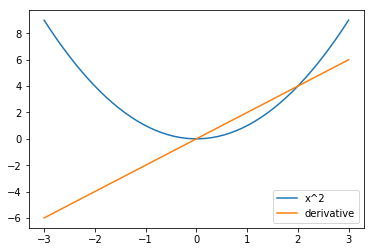

In [20]:
x = np.linspace(-3,3)
x_squared, x_squared_der = s.run([scalar_squared,derivative],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend();

# Why that rocks

In [21]:
my_vector = tf.placeholder('float32',[None])
my_scalar = tf.placeholder('float32')

#Compute the gradient of the next weird function over my_scalar and my_vector
#warning! Trying to understand the meaning of that function may result in permanent brain damage

weird_psychotic_function = tf.reduce_mean((my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 1./ tf.atan(
    my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2)*tf.exp(
    (my_scalar-4)**2)/(1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2))/(1+tf.exp(-(my_scalar-4)**2)))**2

### Excercise 1.4: automatic differentiation

In this exercise you witness the power of automatic differentiation performed by tensorflow.

Just use the example above.

In [22]:
der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

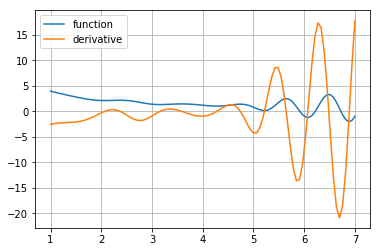

In [23]:
#Plotting your derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic grads from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [24]:
y_guess = tf.Variable(np.zeros(2,dtype='float32'))
y_true = tf.range(1,3,dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 

optimizer = tf.train.MomentumOptimizer(0.01,0.9).minimize(loss,var_list=y_guess)

#same, but more detailed:
#updates = [[tf.gradients(loss,y_guess)[0], y_guess]]
#optimizer = tf.train.MomentumOptimizer(0.01,0.9).apply_gradients(updates)

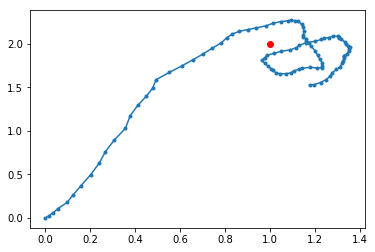

In [25]:
from IPython.display import clear_output

s.run(tf.global_variables_initializer())

guesses = [s.run(y_guess)]

for _ in range(100):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    
    clear_output(True)
    plt.plot(*zip(*guesses),marker='.')
    plt.scatter(*s.run(y_true),c='red')
    plt.show()

### Just for fun, try the same with some other optimizer and observe the results. Possible choices include
* GradientDescentOptimizer
* RMSPropOptimizer
* AdamOptimizer
* ...

In [26]:
optimizer = tf.train.RMSPropOptimizer(0.1).minimize(loss,var_list=y_guess)

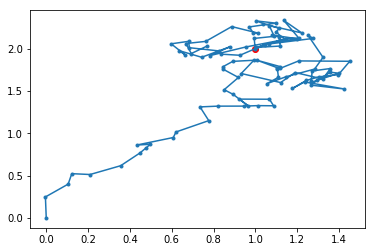

In [27]:
s.run(tf.global_variables_initializer())

guesses = [s.run(y_guess)]

for _ in range(100):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    
    clear_output(True)
    plt.plot(*zip(*guesses),marker='.')
    plt.scatter(*s.run(y_true),c='red')
    plt.show()

# Exercise 1.5: LOGISTIC REGRESSION

Implement the regular logistic regression training algorithm

Tips:
* Define shared variables for weights and biases
* Define placeholders x and y for data and labels
* Compile a function:
 * `pred(x, W, b)` - computes class probabilities given parameters and data
 
We shall train on a MNIST dataset

In [28]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [29]:
_X, _y = sample = mnist.train.next_batch(batch_size=1)

In [30]:
_X.shape, _y.shape

((1, 784), (1, 10))

### Define placeholders for data and labels

In [31]:
# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784, so shape should be [None, 784]
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes, so shape should be ???

### Define variables for data and labels

In [32]:
# Define Variables for model weights
# Initialize them with zeros using tf.zeros
W = tf.Variable(tf.zeros([784, 10])) # should be of shape [784, 10]
b = tf.Variable(tf.zeros([10])) # should be of shape [10]

### Build a function to predict class given data and weights

$$y = x*W + b$$

$$prediction = softmax(y)$$

In [33]:
# hint: use tf.nn.softmax to compute softmax
pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

### Compile a function to compute loss predictions and true labels

In [34]:
# Minimize error using cross entropy loss
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred)))
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [35]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                          y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))
    
    final_weights = W.eval()

Epoch: 0001 cost= 42.677600427
Epoch: 0002 cost= 32.078229575
Epoch: 0003 cost= 30.466851420
Epoch: 0004 cost= 29.645799505
Epoch: 0005 cost= 29.369796515
Epoch: 0006 cost= 28.741336272
Epoch: 0007 cost= 28.586760193
Epoch: 0008 cost= 28.251671635
Epoch: 0009 cost= 28.003301763
Epoch: 0010 cost= 27.957781629
Epoch: 0011 cost= 27.833988237
Epoch: 0012 cost= 27.783464935
Epoch: 0013 cost= 27.323994487
Epoch: 0014 cost= 27.553133163
Epoch: 0015 cost= 27.508329195
Epoch: 0016 cost= 27.267823117
Epoch: 0017 cost= 26.988965140
Epoch: 0018 cost= 27.097339018
Epoch: 0019 cost= 26.734559947
Epoch: 0020 cost= 26.837104746
Epoch: 0021 cost= 26.775527693
Epoch: 0022 cost= 26.714307001
Epoch: 0023 cost= 26.526456378
Epoch: 0024 cost= 26.538062305
Epoch: 0025 cost= 26.487788930
Optimization Finished!
Accuracy: 0.9234


### Visualize the weights that we ended up with

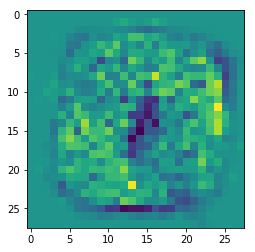

In [36]:
plt.imshow(final_weights[:,0].reshape([28,28]))

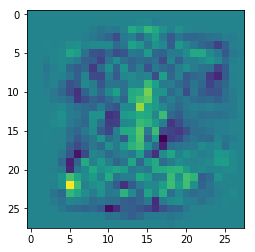

In [37]:
plt.imshow(final_weights[:,1].reshape([28,28]))

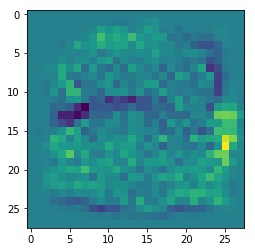

In [38]:
plt.imshow(final_weights[:,2].reshape([28,28]))